In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.callbacks import EarlyStopping

C:\Users\AHMED\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
TC= pd.read_csv("GlobalLandTemperaturesByCountry.csv", encoding='ISO-8859-1')
TC=TC.dropna()
TC['dt'] = pd.to_datetime(TC['dt'])
unique_count = TC['Country'].nunique()
print(unique_count)
TC_6013=TC.drop(TC[TC['dt'] < "1960-01-01" ].index)
TC_6013.set_index("dt", inplace=True)
TUN_TC= TC_6013[TC_6013["Country"]=="Tunisia"]
print(TUN_TC.head())


242
            AverageTemperature  AverageTemperatureUncertainty  Country
dt                                                                    
1960-01-01              10.787                          0.579  Tunisia
1960-02-01              14.914                          0.912  Tunisia
1960-03-01              16.294                          0.163  Tunisia
1960-04-01              17.377                          0.788  Tunisia
1960-05-01              23.370                          0.651  Tunisia


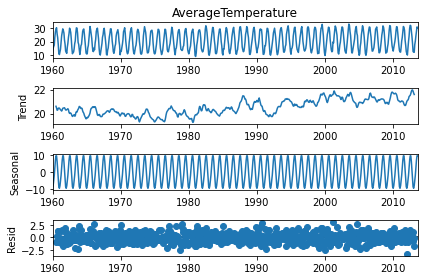

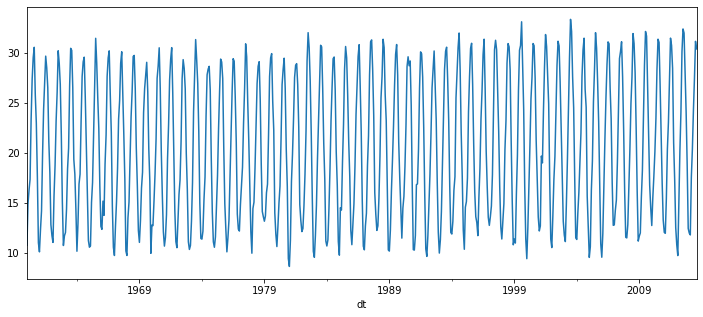

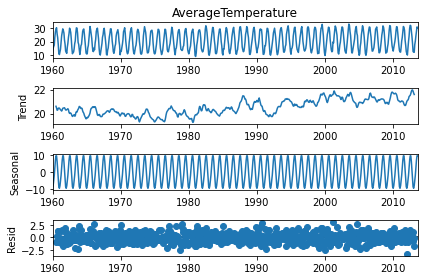

In [3]:
#STUDYING THE DATA OF TUNISIA 
TUN_TC["AverageTemperature"].plot(figsize=(12,5))
results = seasonal_decompose(TUN_TC['AverageTemperature'])
results.plot()

In [4]:
#LSTM MODEL
train=TUN_TC.iloc[:-30][["AverageTemperature"]]
test=TUN_TC.iloc[-30:][["AverageTemperature"]]
print(train)
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
scaled_train[:10]
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model.fit(generator,epochs=50,callbacks=[early_stop])



            AverageTemperature
dt                            
1960-01-01              10.787
1960-02-01              14.914
1960-03-01              16.294
1960-04-01              17.377
1960-05-01              23.370
...                        ...
2010-10-01              21.911
2010-11-01              16.943
2010-12-01              13.291
2011-01-01              12.075
2011-02-01              11.981

[614 rows x 1 columns]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________________________________________

602/602 [==============================] - 2s 3ms/step - loss: 0.0025
Epoch 28/50
602/602 [==============================] - 2s 3ms/step - loss: 0.0028
Epoch 29/50
602/602 [==============================] - 2s 4ms/step - loss: 0.0025
Epoch 30/50
602/602 [==============================] - 2s 4ms/step - loss: 0.0025
Epoch 31/50
602/602 [==============================] - 2s 3ms/step - loss: 0.0025
Epoch 32/50
602/602 [==============================] - 2s 3ms/step - loss: 0.0025
Epoch 33/50
602/602 [==============================] - 2s 3ms/step - loss: 0.0025
Epoch 34/50
602/602 [==============================] - 2s 3ms/step - loss: 0.0025
Epoch 35/50
602/602 [==============================] - 2s 3ms/step - loss: 0.0024
Epoch 36/50
602/602 [==============================] - 2s 3ms/step - loss: 0.0026
Epoch 37/50
602/602 [==============================] - 2s 3ms/step - loss: 0.0024
Epoch 38/50
602/602 [==============================] - 2s 3ms/step - loss: 0.0025
Epoch 39/50
602/602 [=======

1/1 [==============================] - 0s 17ms/step


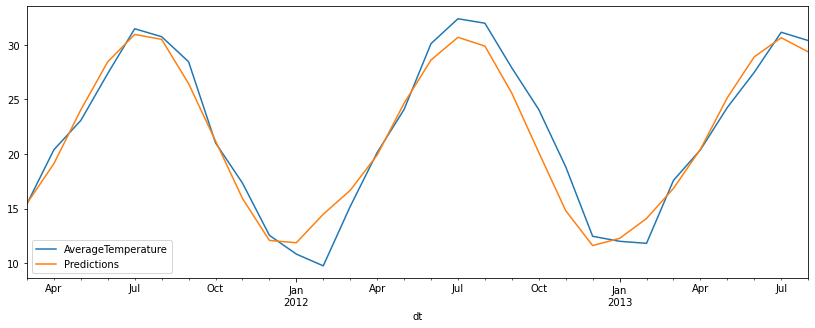

In [5]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(14,5))
rmse=sqrt(mean_squared_error(test['AverageTemperature'],test['AverageTemperature']))